## Problem Statement

#### Credit Caerd Fraud Detection using Isolation Forest.
#### Dataset: Credit Card Fraud Detection dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
#### This project aim to train an Isolation Forest model on the provided dataset. This is an unsupervised problem, so labels are in access, but we are not allowed to use them in the training procedure. However, labels can be used in the Exploratory Data Analysis stage and evaluation, in order to better understand the the data distribution. Our final goal is to find a robust and reliable model, with good performance in both metrics, precision and recall.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support
import warnings


C:\Users\Bahador\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\Bahador\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=T

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Dataset Overview

In [3]:
data_path = "../data/creditcard.csv"
data = pd.read_csv(data_path)

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
print("Number of rows(samples):" + str(data.shape[0]))
print("Number of columns(features):" + str(data.shape[1] - 1) + " independent variables and 1 dependent variable")

Number of rows(samples):284807
Number of columns(features):30 independent variables and 1 dependent variable


#### We see that the data contains 284807 samples, each of them showing a transaction. Each transaction has 30 independent variable as follows: 
#### - Amount: The amount of money transferred in each transaction. 
#### - Time: The time of transaction. Note that time is not recorded in regular form of date and hour. Instead, it is recorded as the second, starting from 0 to 124592. 
#### - 28 principal components (V1, V2, V3, ..., V28), extracted by PCA performed on the raw data which is confidential. 
#### - Class: A binary column representing the dependent variable. '1' shows fraudulent transaction, and '0' shows a normal transaction. Note that all the independent variables are floats, and there is no missing value!

In [6]:
for i in zip(data.columns, data.dtypes):
    print(i[0] + ':' + str(i[1]))
 

Time:float64
V1:float64
V2:float64
V3:float64
V4:float64
V5:float64
V6:float64
V7:float64
V8:float64
V9:float64
V10:float64
V11:float64
V12:float64
V13:float64
V14:float64
V15:float64
V16:float64
V17:float64
V18:float64
V19:float64
V20:float64
V21:float64
V22:float64
V23:float64
V24:float64
V25:float64
V26:float64
V27:float64
V28:float64
Amount:float64
Class:int64


In [7]:
print("Number of missing values: " + str(data.isna().sum().sum()))

Number of missing values: 0


In [8]:
dep_var = data['Class']

In [9]:
print("Number of positives (Not Fraud): " + str((dep_var == 0).sum()) + " ----> " + str(round(100*(dep_var == 0).sum()/len(dep_var), 5)) + "%")
print("Number of negatives (Fraud): " + str((dep_var == 1).sum()) + " ----> " + str(round(100*(dep_var == 1).sum()/len(dep_var), 5)) + "%")

Number of positives (Not Fraud): 284315 ----> 99.82725%
Number of negatives (Fraud): 492 ----> 0.17275%


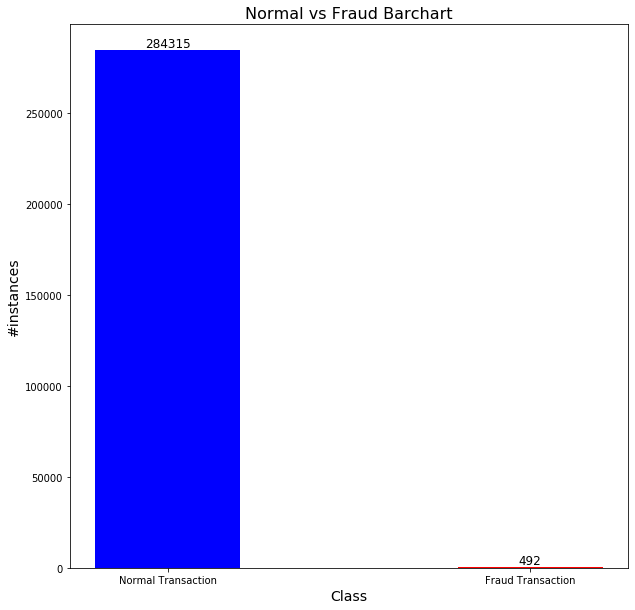

In [10]:
plt.figure(figsize=(10, 10))
bars = plt.bar(dep_var.unique(), [(dep_var == 0).sum(), (dep_var == 1).sum()], tick_label = ['Normal Transaction','Fraud Transaction'], color = ['blue', 'red'], width=0.4)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{bar.get_height():.0f}', ha='center', va='bottom', fontsize=12)
plt.xlabel("Class", fontsize=14)
plt.ylabel("#instances", fontsize=14)
plt.title("Normal vs Fraud Barchart", fontsize=16)
plt.show()


#### Regarding "Normal vs Fraud" barchart, the number of instances labeled as fraud, is significantly lower than that of the normal transactions. there are only 492 fraud transactions in the dataset, which is 0.173% of the total number of transaction. So, the dataset is extremely imbalanced.

## Exploratory Data Analysis (EDA)

### Amount vs Time

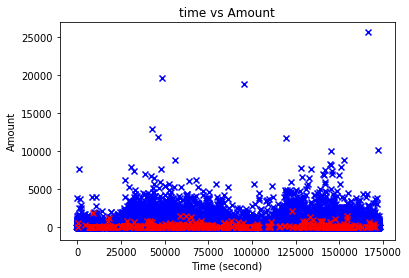

In [11]:
plt.figure()
plt.scatter(data['Time'].loc[data['Class'] == 0], data['Amount'].loc[data['Class'] == 0], c='blue', marker='x')
plt.scatter(data['Time'].loc[data['Class'] == 1], data['Amount'].loc[data['Class'] == 1], c='red', marker='x')
plt.xlabel('Time (second)')
plt.ylabel('Amount')
plt.title('time vs Amount')
plt.show()

#### The scatter plot named "Time vs Amount", depicts the distribution of the points based on these two variables. It is evident that fraud transactions tend to be relatively small in the amount, which is not surprising. The smaller amount for a fraudulent transaction is harder to detect and less likely to raise suspicion.

### PCA Scatter plot

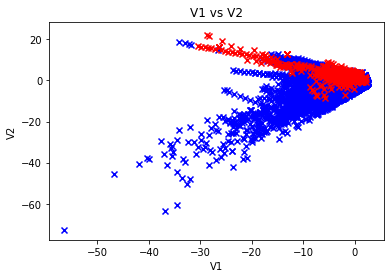

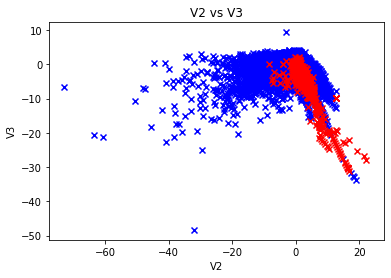

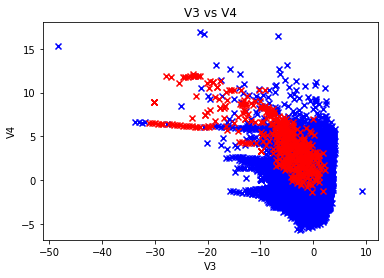

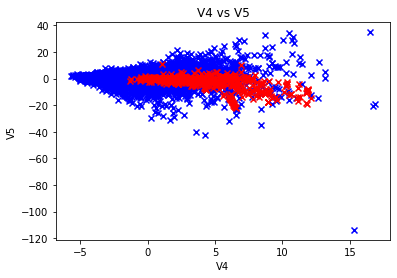

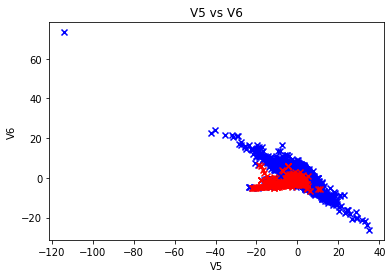

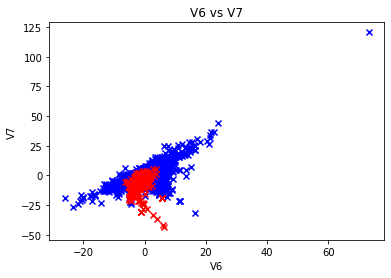

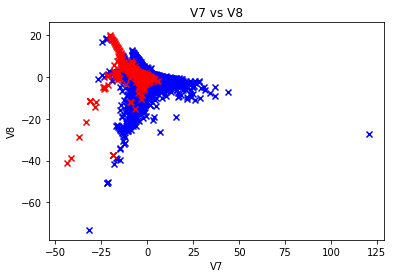

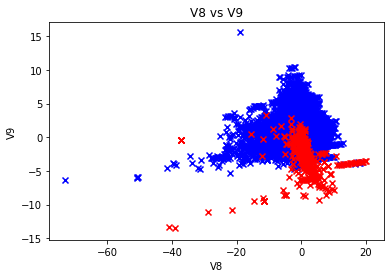

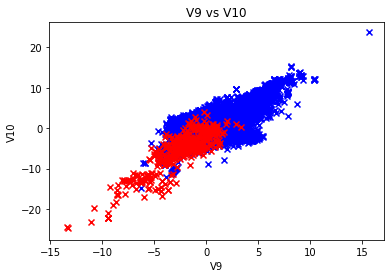

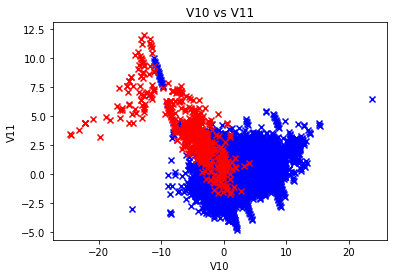

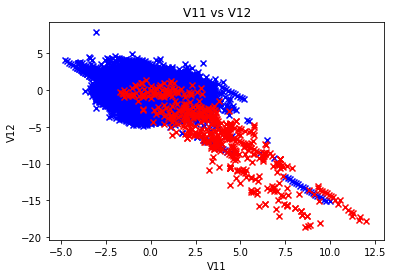

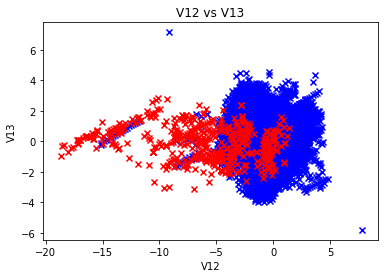

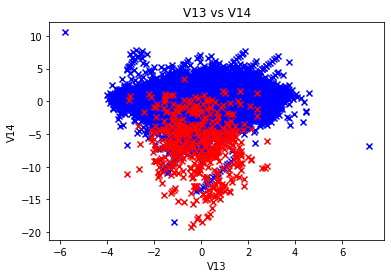

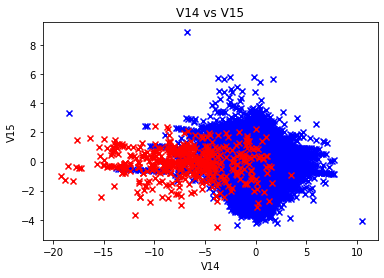

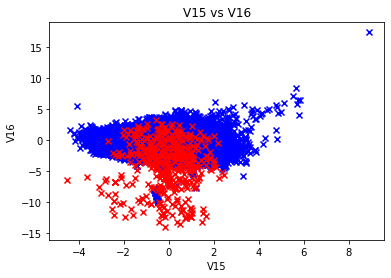

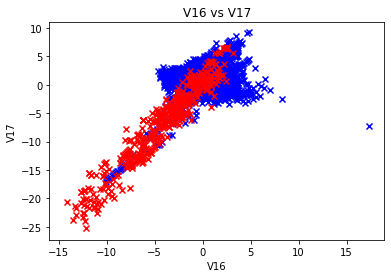

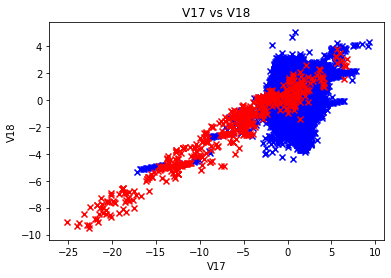

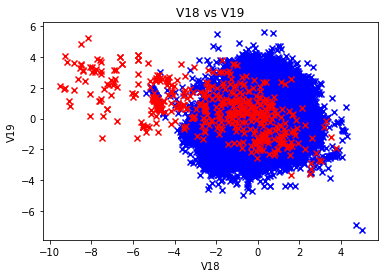

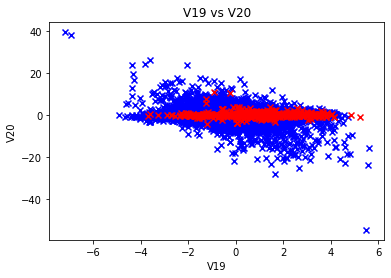

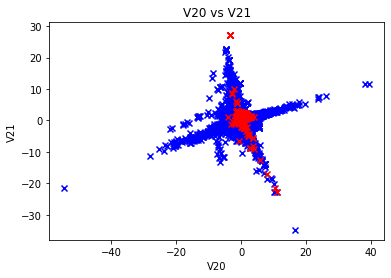

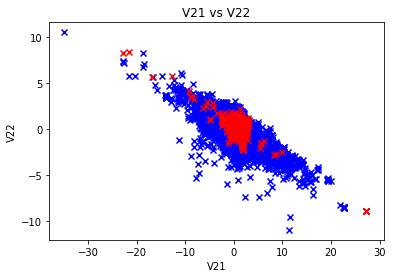

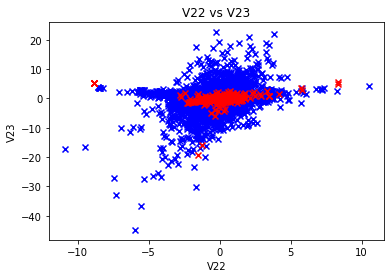

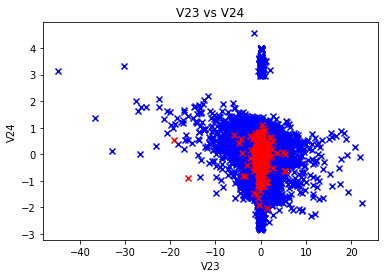

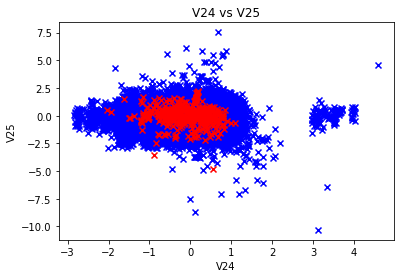

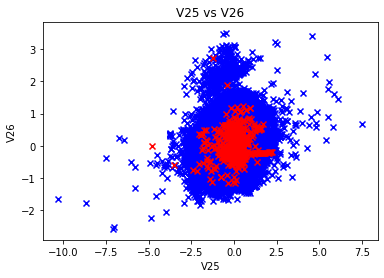

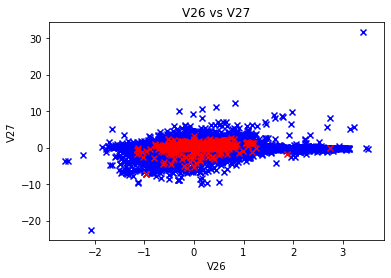

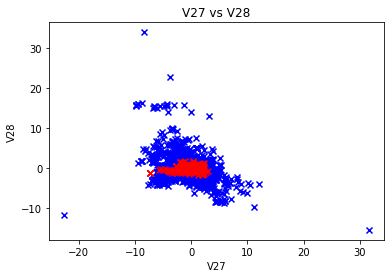

In [12]:
for i in range(27):
    plt.figure()
    plt.scatter(data['V' + str(i+1)].loc[data['Class'] == 0], data['V' + str(i+2)].loc[data['Class'] == 0], c='blue', marker='x')
    plt.scatter(data['V' + str(i+1)].loc[data['Class'] == 1], data['V' + str(i+2)].loc[data['Class'] == 1], c='red', marker='x')
    plt.xlabel('V' + str(i+1))
    plt.ylabel('V' + str(i+2))
    plt.title('V' + str(i+1) + ' vs ' + 'V' + str(i+2))
    plt.show()


#### The scatter plot of the principal components were also generated. It can be observed that the first PCs are more effective in separating the fraudulent instances from the normal ones, indicating that they carry more informative signals. Note that there is overlap between classes, even in the more informative PCs, which means that a linear model may not be so effective in detecting the fraudulent transactions.
#### Another important insight drawn from the plots, is that the fraudulent samples tend to be concentrated in specific regions, whereas normal transactions are more widely dispersed. 

### Amount

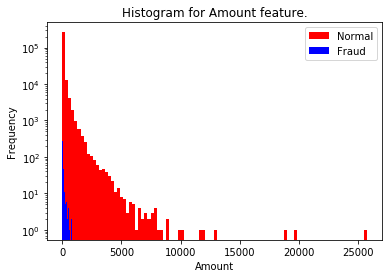

In [13]:
plt.figure()
plt.hist(data.query('Class == 0')['Amount'], bins = 100, log=True, color='red')
plt.hist(data.query('Class == 1')['Amount'], bins = 100, log=True, color='blue')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Histogram for Amount feature.')
plt.legend(['Normal', 'Fraud'])
plt.show()

#### The histogram generated for amount, confirms our previous findings about the nature of the fraudulent transaction. It can be seen that fraudulent ones tend to be relatively small in amount.

C:\Users\Bahador\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Bahador\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


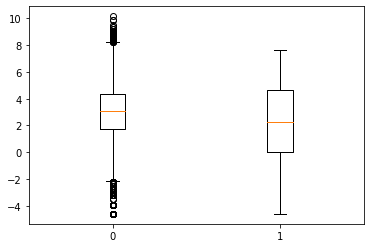

In [14]:
classes = np.unique(data['Class'])
grouped_dict = {np.unique(data['Class'])[0]:np.log(data[data['Class'] == np.unique(data['Class'])[0]]['Amount']),
               np.unique(data['Class'])[1]:np.log(data[data['Class'] == np.unique(data['Class'])[1]]['Amount'])}

plt.boxplot(grouped_dict.values(), labels=grouped_dict.keys())
plt.show()

#### The boxplots were generated based on the amount of transaction for each class. They show that normal transactions are more dispersed ralative to the fraudulent ones, while the fraudulent ones are concentrated around the median, without considerable variation.

### Violon Plot and Scatter plot based on difference in medians between normal and fraud instances

In [15]:
classes = np.unique(data['Class'])
grouped_dict_V1 = {np.unique(data['Class'])[0]:data[data['Class'] == np.unique(data['Class'])[0]]['V1'],
                   np.unique(data['Class'])[1]:data[data['Class'] == np.unique(data['Class'])[1]]['V1']}


In [16]:
def violin_plot_V(data, feature_name = 'V1'):
    classes = np.unique(data['Class'])
    grouped_dict_V = {np.unique(data['Class'])[0]:data[data['Class'] == np.unique(data['Class'])[0]][feature_name],
                   np.unique(data['Class'])[1]:data[data['Class'] == np.unique(data['Class'])[1]][feature_name]}

    
    fig, (ax1, ax2) = plt.subplots(nrows = 1, 
                                   ncols = 2,
                                   figsize =(9, 4),
                                   sharey = True)

    ax1.set_title('Normal Transactions')
    ax1.set_ylabel('Observed value for ' + feature_name)
    ax1.violinplot(grouped_dict_V[0], showmedians = True)


    ax2.set_title('Fraudulent Transactions')
    ax2.set_ylabel('Observed value for ' + feature_name)
    ax2.violinplot(grouped_dict_V[1], showmedians = True)


    plt.show()
    
    return([grouped_dict_V[0].median(), grouped_dict_V[1].median()])
    

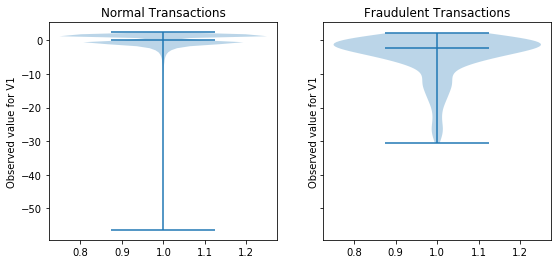

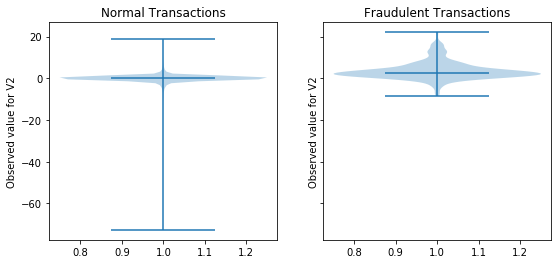

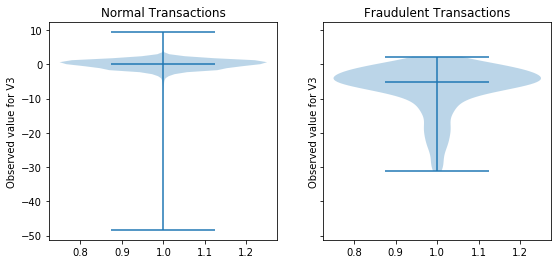

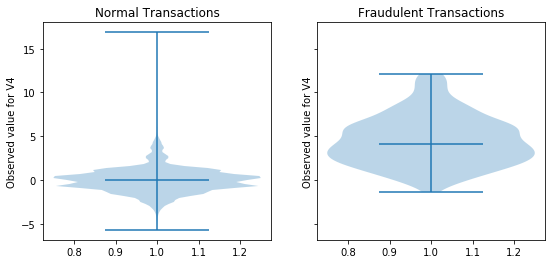

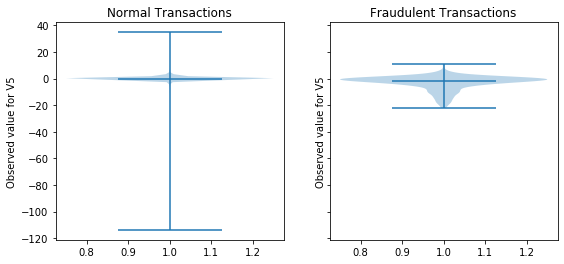

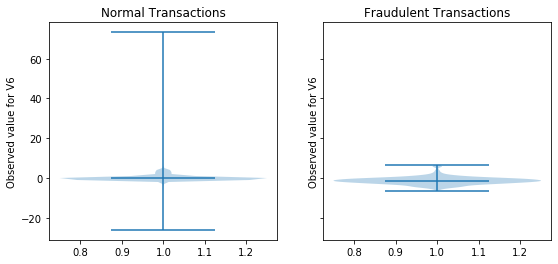

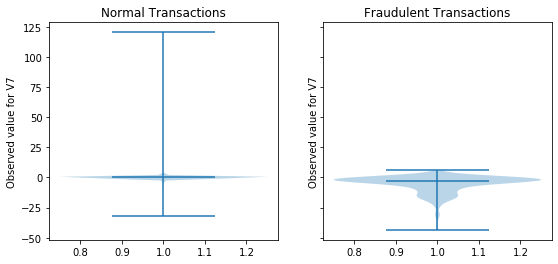

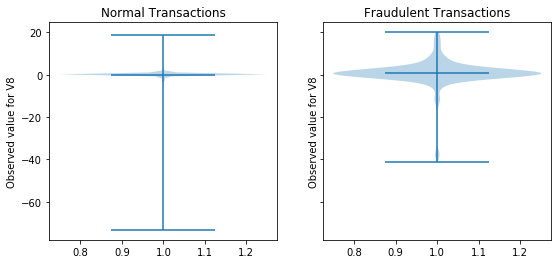

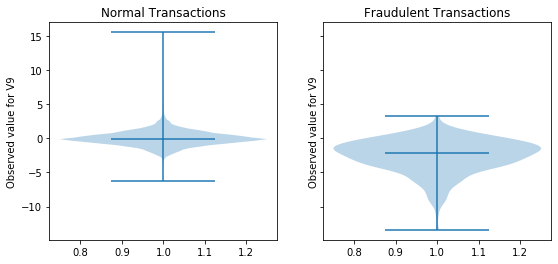

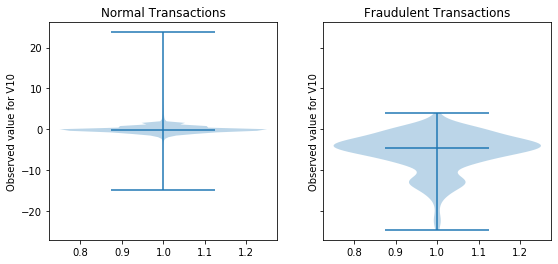

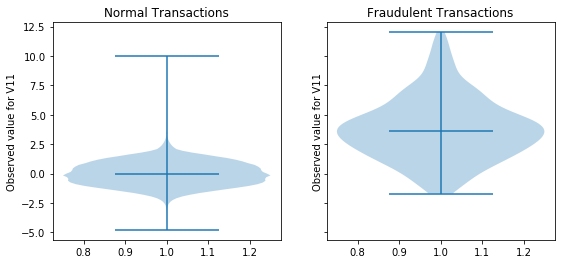

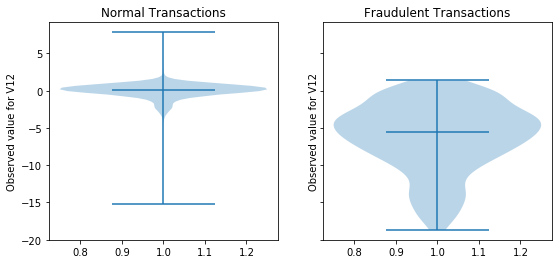

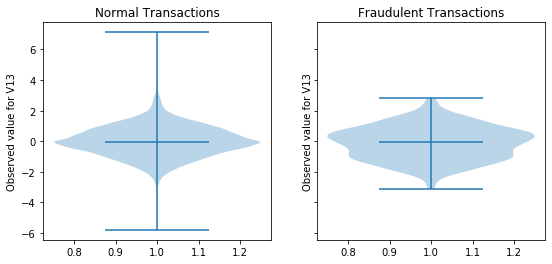

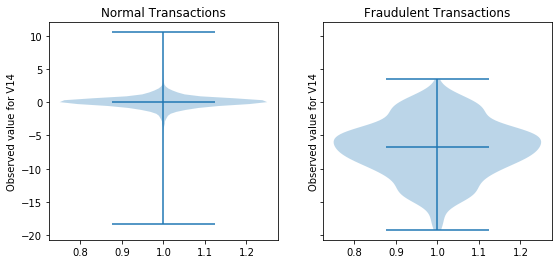

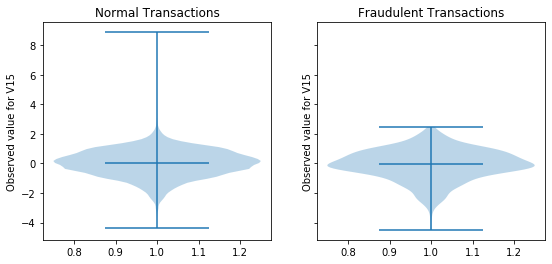

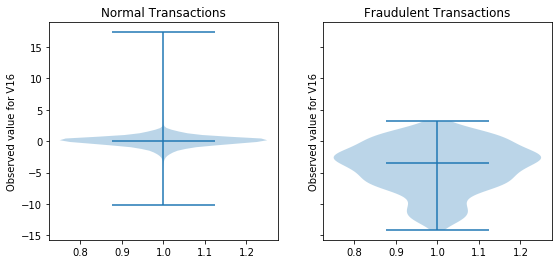

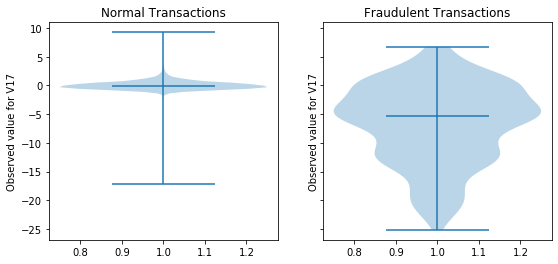

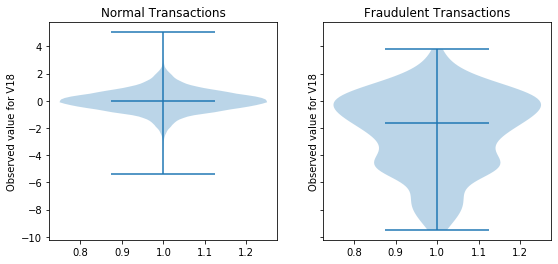

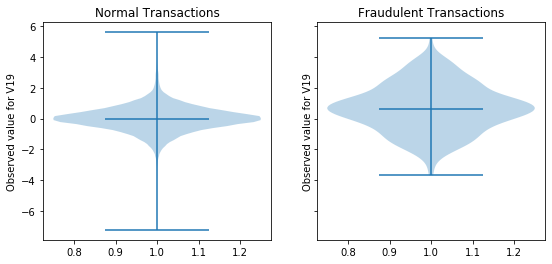

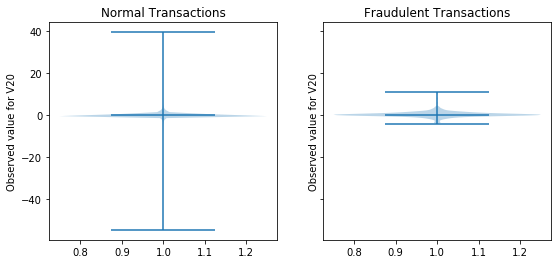

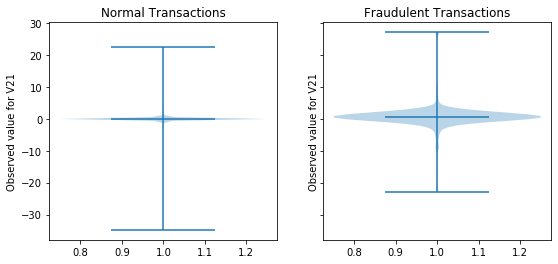

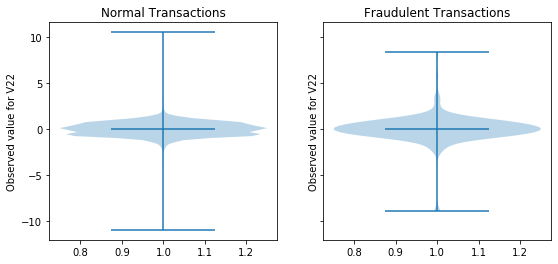

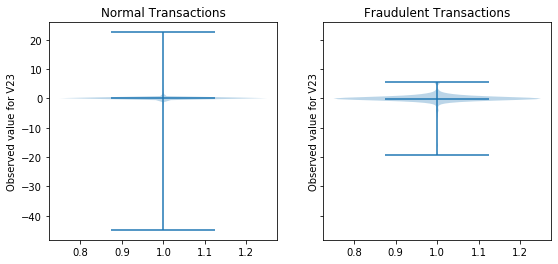

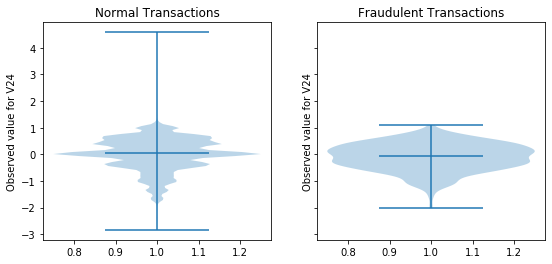

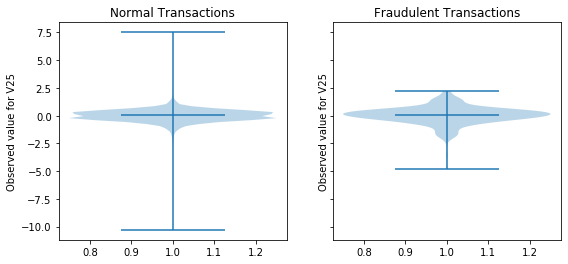

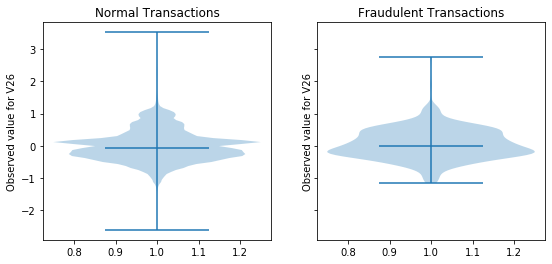

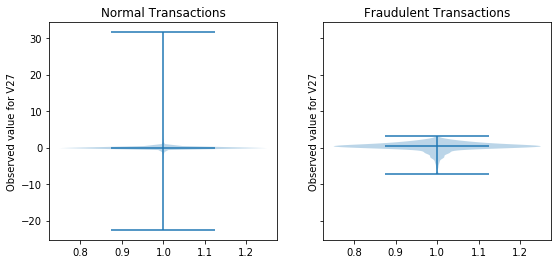

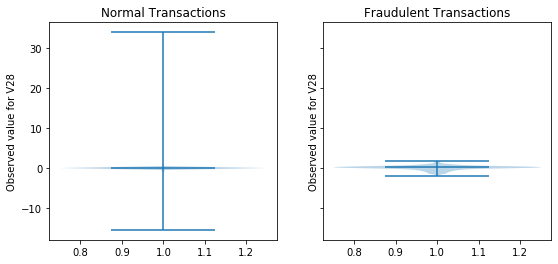

In [17]:
median_0 = []
median_1 = []
for i in range(28):
    med = violin_plot_V(data, 'V'+str(i+1))
    median_0.append(med[0])
    median_1.append(med[1])
medians = [median_0, median_1]

#### Two violin plots were generated for each PC, showing its distribution for each class. Regarding the violin plots, classes usually have overlap, indicating that it is impossible to get a good result by training a linear model on the data. So it is better to choose a more complex model.

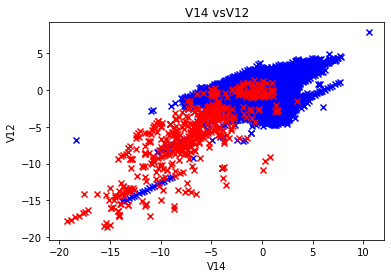

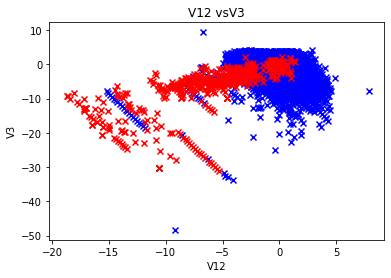

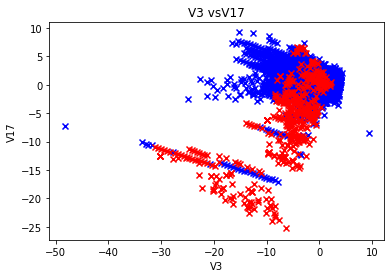

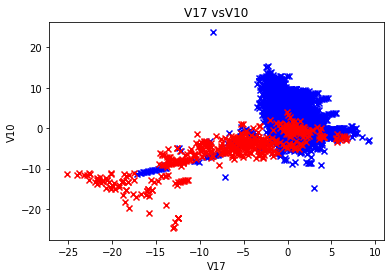

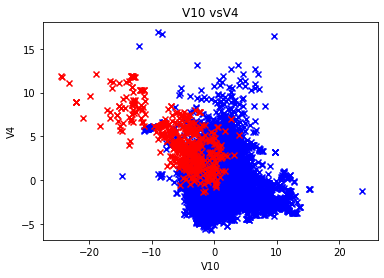

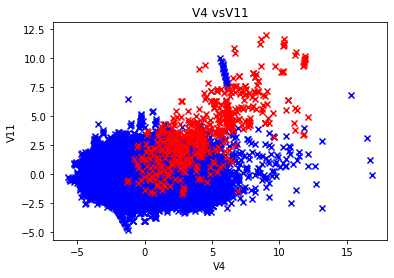

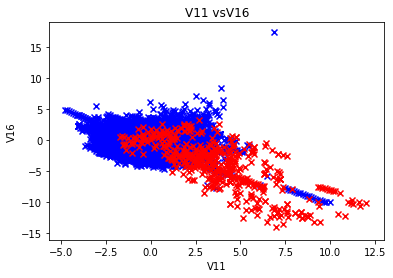

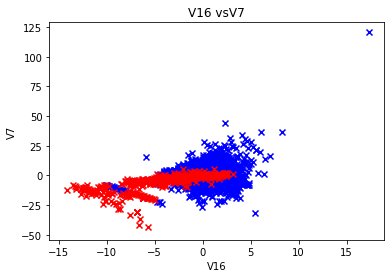

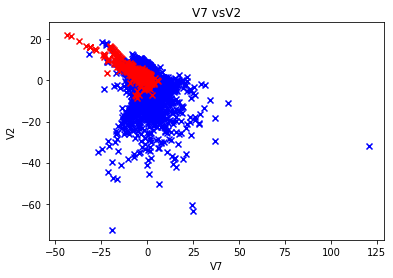

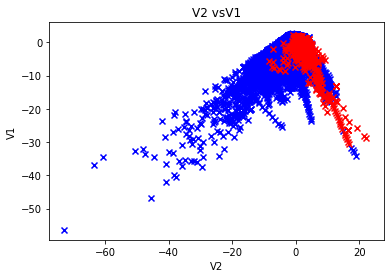

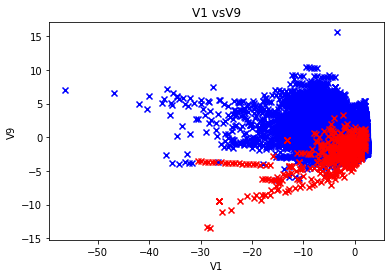

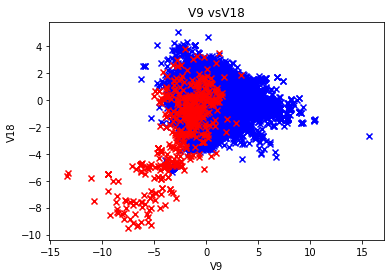

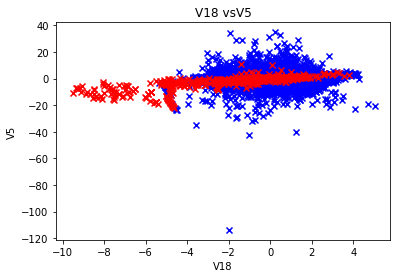

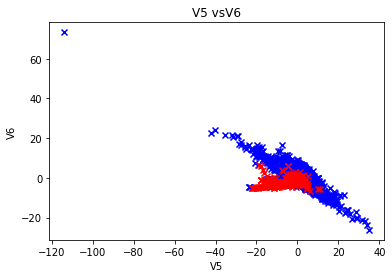

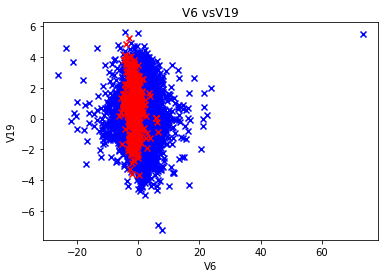

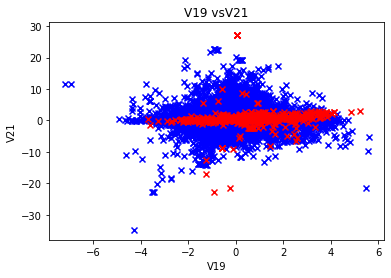

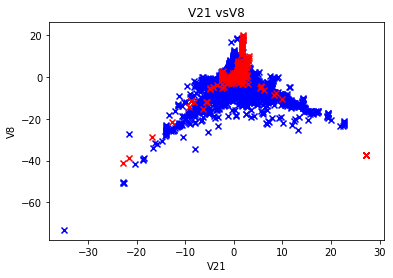

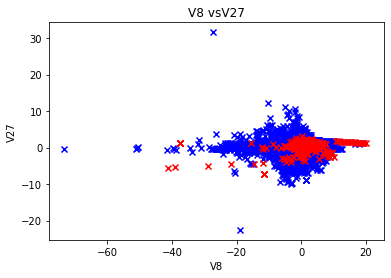

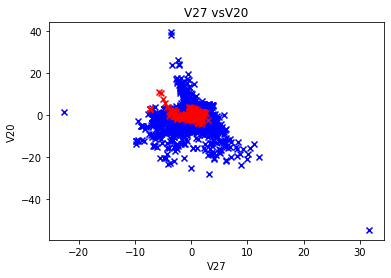

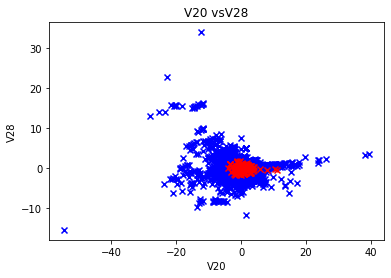

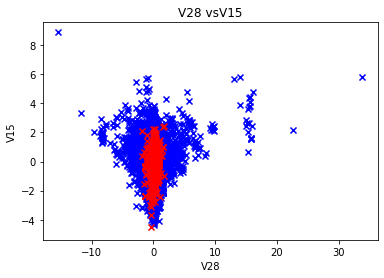

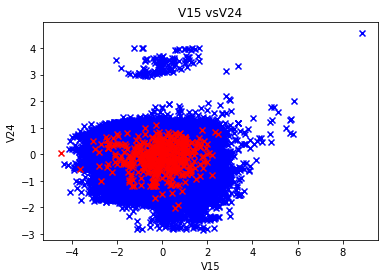

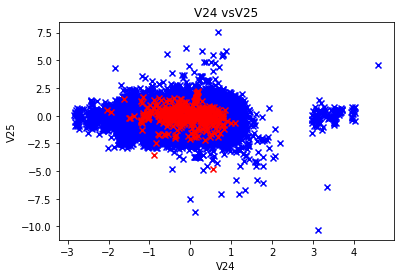

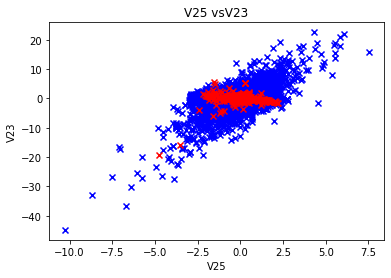

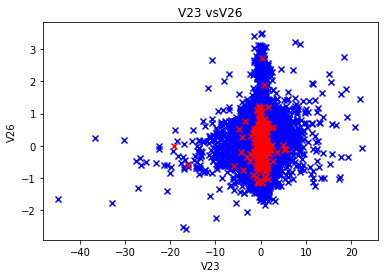

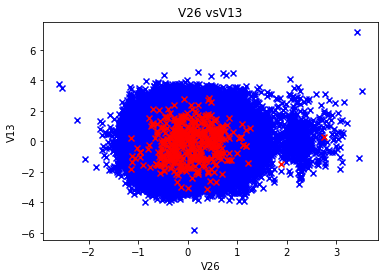

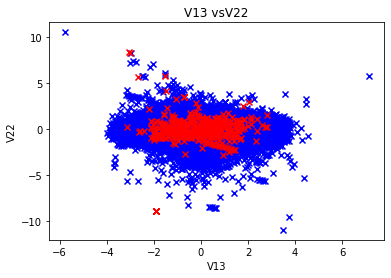

In [18]:


dif_med = np.abs(np.array(medians[0]) - np.array(medians[1]))
dif_med = pd.DataFrame(dif_med, columns=['difference'])

dif_med.sort_values(by=['difference'], ascending=False, inplace=True)
dif_med.index +=1

for k in range(0, len(dif_med.index) - 1):
    i, j = dif_med.index[k], dif_med.index[k+1]
    plt.figure()
    plt.scatter(data['V' + str(i)].loc[data['Class'] == 0], data['V' + str(j)].loc[data['Class'] == 0], c='blue', marker='x')
    plt.scatter(data['V' + str(i)].loc[data['Class'] == 1], data['V'+str(j)].loc[data['Class'] == 1], c='red', marker='x')
    plt.xlabel('V' + str(i))
    plt.ylabel('V' + str(j))
    plt.title('V' + str(i) + ' vs' +  'V' + str(j))
    plt.show()

#### Medians of PCs are usually almost equal, however, There are some PCs which seemed to be more informative (based on shifts in their median for each class). So, the PCs were sorted based on the difference of their medians for each class. Then the scatter plots of the pairs of PCs, from highest difference to the lowest one, were generated. We see that those PCs, which are more deviated in terms of their class-wise medians, are more capable to separate frauds from normal samples.

### Correlation vs Class

In [19]:
corr = []
labels = []
for i in range(28):
    corr.append(np.corrcoef(data['V'+str(i+1)] ,data['Class'])[0,1])
    labels.append(i+1)
corr = [labels, corr]

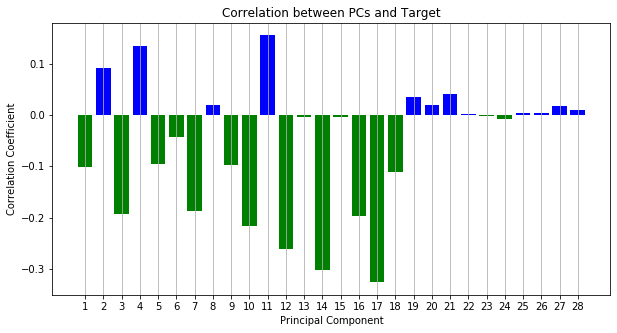

In [20]:
plt.figure(figsize=(10,5))
colors = ['b' if e >= 0 else 'g' for e in corr[1]]
plt.bar(corr[0], corr[1], color = colors, tick_label = corr[0])
plt.grid(axis='x')
plt.xlabel('Principal Component')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation between PCs and Target')
plt.show()

#### Interestingly, features with larger shifts in class-wise medians also tend to exhibit stronger correlation with the target variable. This indicates that both median differences and correlation can serve as complementary indicators of a feature’s informativeness for distinguishing fraudulent transactions.

### Feature Selection

In [21]:
abs_corr = pd.DataFrame(np.abs(corr[1]), columns=['correlation'])
abs_corr.index += 1
abs_corr = abs_corr.sort_values('correlation', ascending=False)
m = 9
features = []
for i in range(m):
    features.append('V' + str(abs_corr.index[i]))
features.append('Amount')
features.append('Class')

In [22]:
print('Selected features:' )
print(features[:-1])

Selected features:
['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'Amount']


In [23]:
X = data[features]

#### Finally, 9 PCs with highest correlation with target variable were selected as the input features. 'Amount' was also included, because it was partially influential.

## Modeling Strategy

## Isolation Forest

### K-Fold CV

In [24]:
normal_X = X[X['Class'] == 0]
fraud_X = X[X['Class'] == 1]
normal_X.drop(columns='Class', inplace=True)

C:\Users\Bahador\Anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\Bahador\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


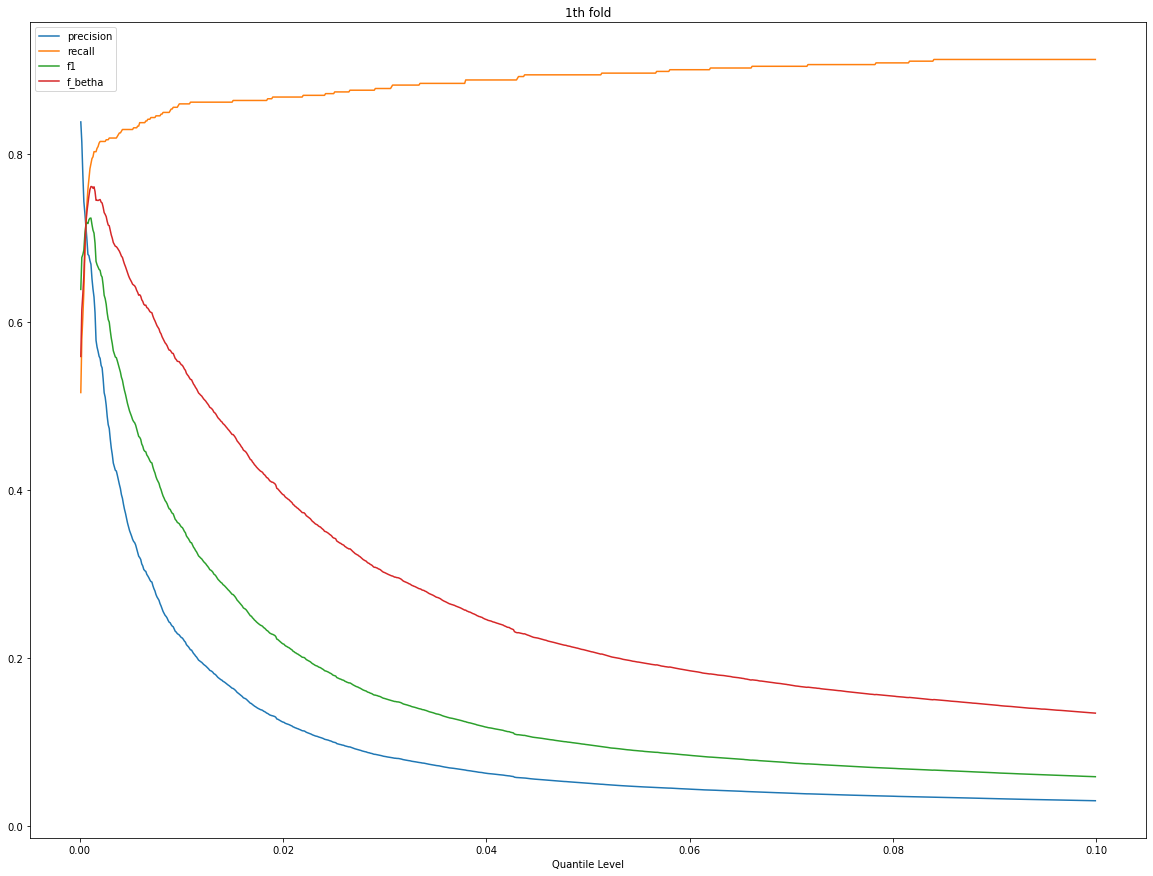

C:\Users\Bahador\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


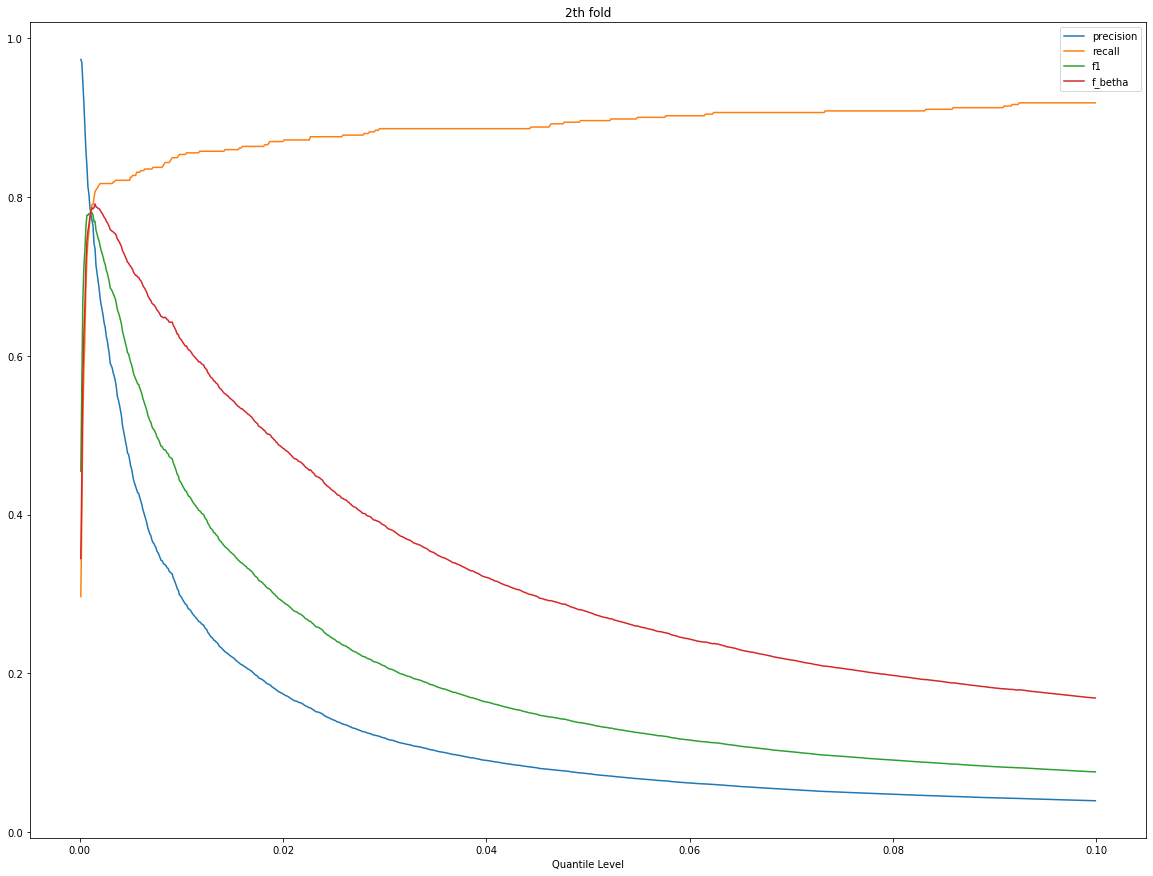

C:\Users\Bahador\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


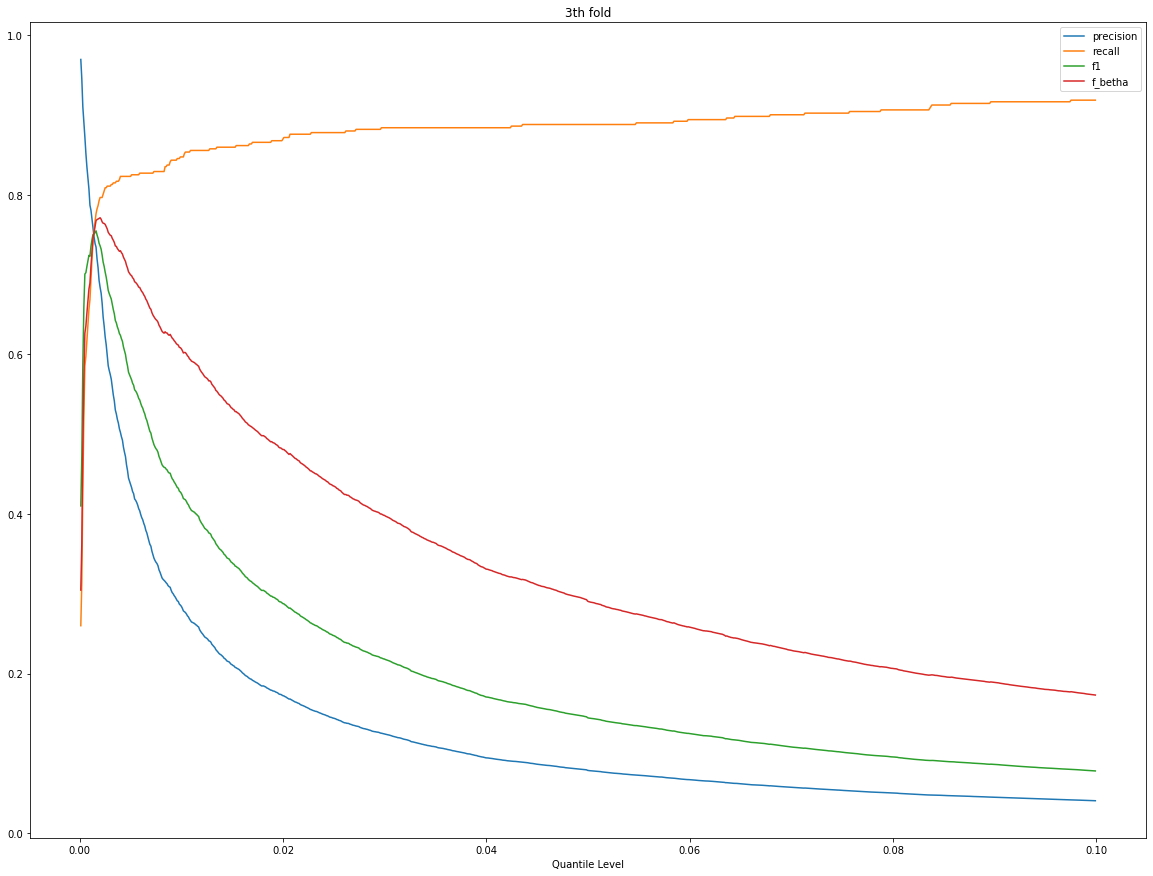

In [26]:
q1 = 0.1
q2 = 0.0001
eps = 1e-19
qs = np.arange(q2, q1, (q1 - q2)/1000)
transformers = []
test_data_cv = []
train_data_cv = []
test_label_cv = []
models = []
threshs = []
precs = []
recs = []
f1s = []
fbs = []
b = 2
kf = KFold(n_splits=3)
for i, (train_index, test_index) in enumerate(kf.split(normal_X)):
    X_train = normal_X.iloc[train_index]
    X_test = normal_X.iloc[test_index]
    X_test = pd.concat([X_test, fraud_X])
    X_test['Class'].loc[X_test['Class'] != 1] = 0
    
    transformer = RobustScaler().fit(X_train)
    scaled_X_train = transformer.transform(X_train)
    scaled_X_train = pd.DataFrame(scaled_X_train, columns=X_train.columns)
    scaled_X_test = transformer.transform(X_test.drop(columns = ['Class']))
    scaled_X_test = pd.DataFrame(scaled_X_test, columns=features[:-1])
    
    model = IsolationForest(n_estimators=100, max_samples=len(X_train), max_features=1.0, behaviour="new").fit(scaled_X_train)
    train_scores = model.decision_function(scaled_X_train)
    test_scores = model.decision_function(scaled_X_test)
    
#    m1 = np.quantile(train_scores, q1)
#    m2 = np.quantile(train_scores, q2)
    
    thresholds = np.quantile(train_scores, qs)
    
    predictions = []
    precisions = []
    recalls = []
    f1_scores = []
    fb_scores = []
    for thresh in thresholds:
        preds = (test_scores < thresh)*1
        prec, rec, f1, _ = precision_recall_fscore_support(X_test['Class'], preds, pos_label=1, average='binary')
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
        
        fb = (1+b**2)*(prec*rec)/(prec*b**2 + rec + eps)
        fb_scores.append(fb)
    
    plt.figure(figsize=(20,15))
    plt.plot(qs, precisions)
    plt.plot(qs, recalls)
    plt.plot(qs, f1_scores)
    plt.plot(qs, fb_scores)
    plt.xlabel('Quantile Level')
    plt.legend(['precision', 'recall', 'f1', 'f_betha'])
    plt.title(str(i+1) + 'th fold')
    plt.show()
    
    precs.append(precisions)
    recs.append(recalls)
    f1s.append(f1_scores)
    fbs.append(fb_scores)
    transformers.append(transformer)
    test_data_cv.append(scaled_X_test)
    train_data_cv.append(scaled_X_train)
    test_label_cv.append(X_test['Class'])
    models.append(model)
    threshs.append(thresholds)
    


#### For model evaluation and threshold tuning, a 3-fold cross-validation strategy was employed. For each fold, four performance metrics — precision, recall, F1-score, and Fβ-score (with β = 2) — were computed across a range of threshold values. These metrics were then visualized using line plots to analyze their behavior under varying decision thresholds. Note that each test set contains all fraudulent transactions due to the highly imbalanced nature of the dataset, while the normal transactions are mutually exclusive across different test sets.

#### The x-axis represents the quantile level used to determine the anomaly detection threshold. This approach was adopted to avoid inconsistencies arising from the fact that raw anomaly scores produced by the Isolation Forest are not directly comparable across different folds.

#### The results indicate that both the F1-score and F2-score initially increase as the quantile level rises, reaching a peak at an intermediate threshold, after which their values start to decline. This behavior reflects the trade-off between precision and recall as the decision boundary becomes more restrictive.

#### Precision increases sharply at lower quantile levels, indicating a rapid reduction in false positives. However, after the optimal quantile corresponding to the maximum F1-score, the rate of increase in precision becomes marginal. At the same time, recall continues to decrease steadily, even when precision has nearly saturated. This trend is expected given the highly imbalanced nature of the dataset, where stricter thresholds disproportionately reduce the detection of minority (fraudulent) samples.

In [27]:
recs_avg_std = np.array([np.mean(recs, axis = 0), np.std(recs, axis = 0)])
precs_avg_std = np.array([np.mean(precs, axis = 0), np.std(precs, axis = 0)])
fbs_avg_std = np.array([np.mean(fbs, axis = 0), np.std(fbs, axis = 0)])
f1s_avg_std = np.array([np.mean(f1s, axis = 0), np.std(f1s, axis = 0)])

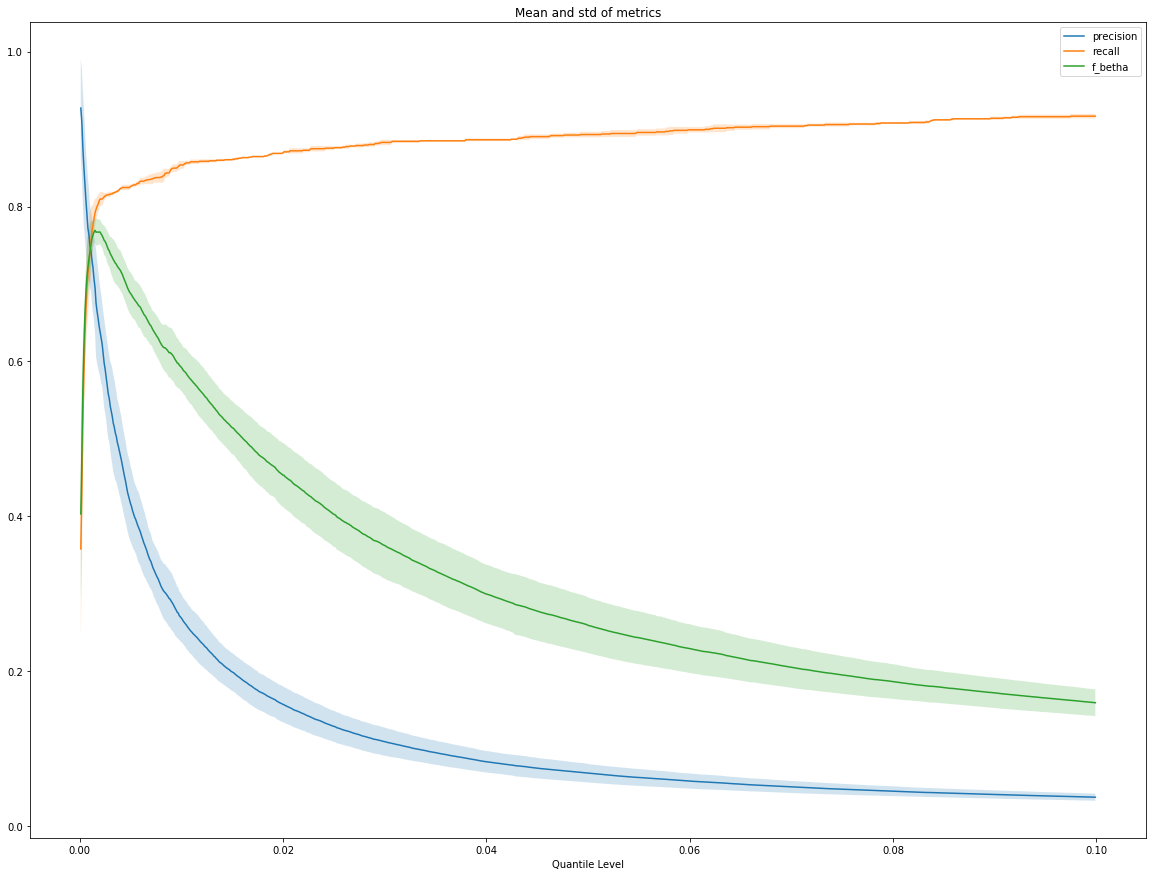

In [28]:
plt.figure(figsize=(20,15))
plt.plot(qs, precs_avg_std[0])
plt.fill_between(qs, precs_avg_std[0] - precs_avg_std[1], precs_avg_std[0] + precs_avg_std[1], alpha = 0.2)
plt.plot(qs, recs_avg_std[0])
plt.fill_between(qs, recs_avg_std[0] - recs_avg_std[1], recs_avg_std[0] + recs_avg_std[1], alpha = 0.2)
plt.plot(qs, fbs_avg_std[0])
plt.fill_between(qs, fbs_avg_std[0] - fbs_avg_std[1], fbs_avg_std[0] + fbs_avg_std[1], alpha = 0.2)

plt.xlabel("Quantile Level")
plt.title("Mean and std of metrics")
plt.legend(['precision', 'recall', 'f_betha'])
plt.show()

#### For the final evaluation, the mean and standard deviation of precision, recall, and Fβ-score (with β = 2) were computed across the cross-validation folds for each quantile level. These aggregated metrics were then visualized to assess the stability of model performance under different threshold choices.

#### The results show that the standard deviation across folds remains relatively low for all three metrics, indicating that the model’s performance is stable and consistent across different data splits. This suggests that the selected thresholding strategy generalizes well and is not overly sensitive to variations in the training and test partitions.

#### An important point to consider is that the model aims to identify the optimal quantile level, which is then used to compute the corresponding decision threshold.

<Figure size 432x288 with 0 Axes>

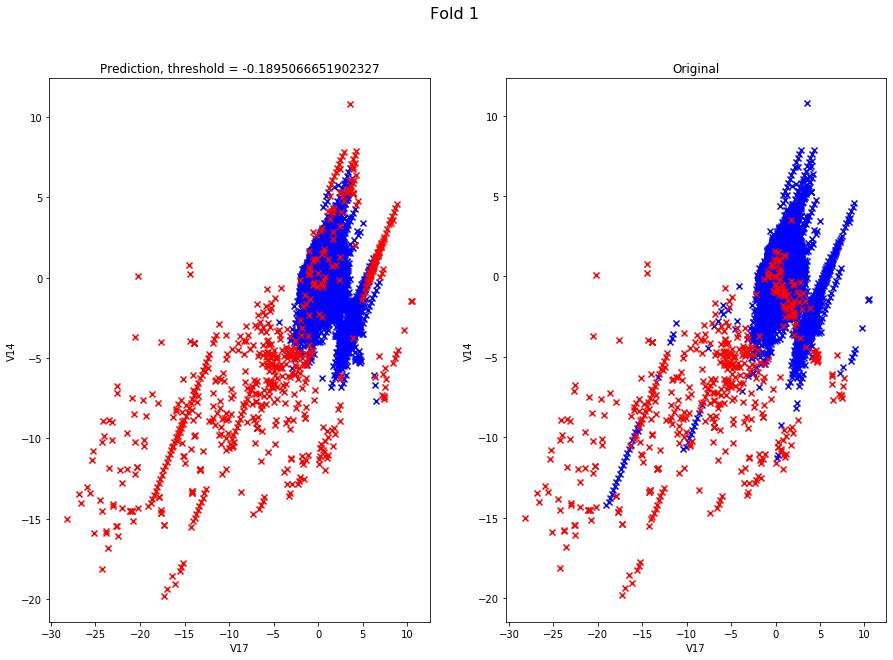

<Figure size 432x288 with 0 Axes>

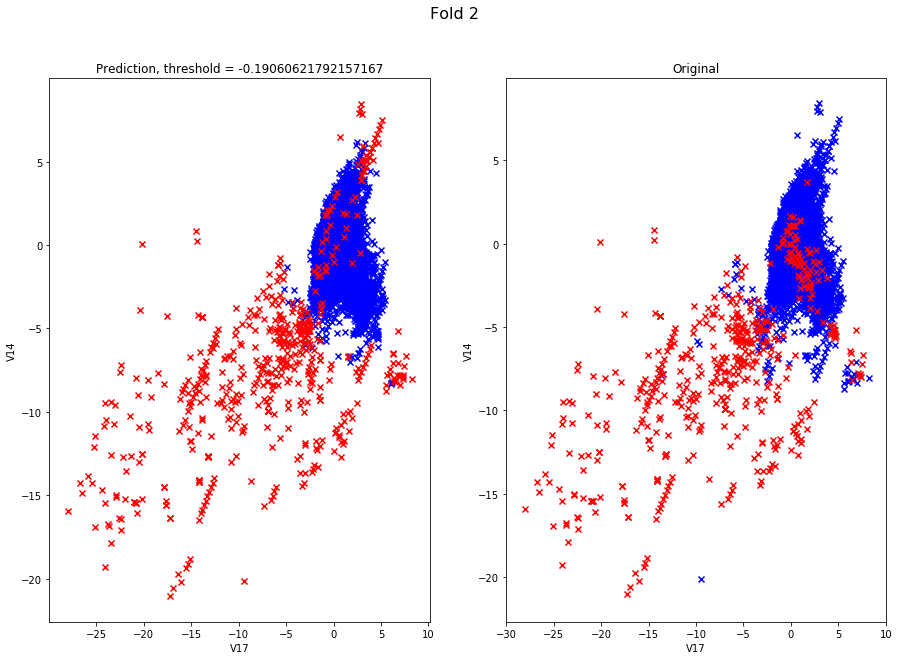

<Figure size 432x288 with 0 Axes>

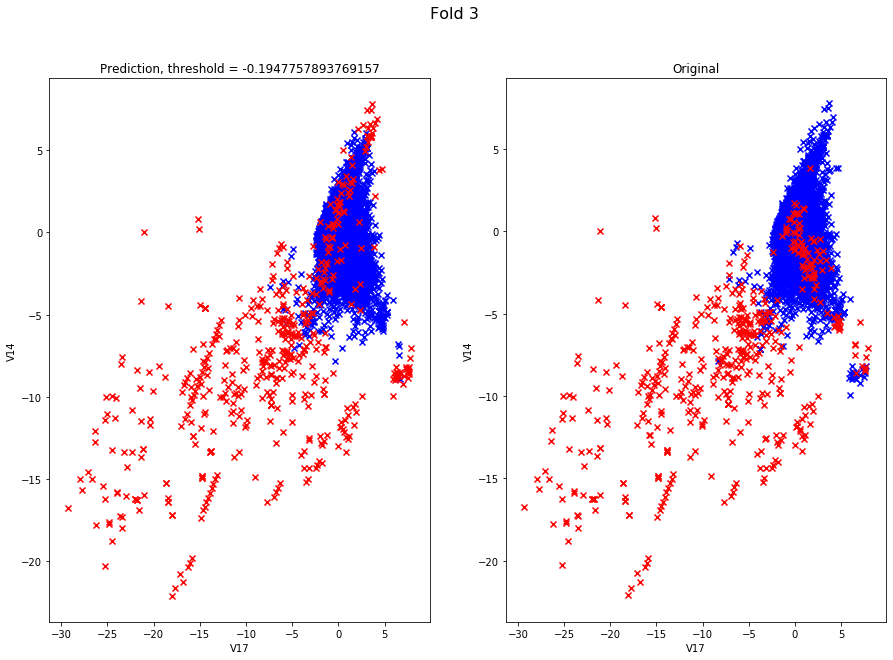

In [29]:
optimal_threshold_idx = np.argmax(fbs_avg_std[0])
scores = []
predictions = []
for i , X_test in enumerate(test_data_cv):
    score = models[i].decision_function(X_test)
    prediction = (score <= threshs[i][optimal_threshold_idx])*1
    
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    fig.suptitle('Fold ' + str(i+1), fontsize=16)

    ax1.scatter(X_test['V17'].iloc[prediction == 0], X_test['V14'].iloc[prediction == 0], c='blue', marker='x')
    ax1.scatter(X_test['V17'].iloc[prediction == 1], X_test['V14'].iloc[prediction == 1], c='red', marker='x')
    ax1.set_xlabel('V17')
    ax1.set_ylabel('V14')
    ax1.set_title('Prediction, threshold = '+str(threshs[i][optimal_threshold_idx]))
    
    ax2.scatter(X_test['V17'].iloc[np.array(test_label_cv[i] == 0)], X_test['V14'].iloc[np.array(test_label_cv[i] == 0)], c='blue', marker='x')
    ax2.scatter(X_test['V17'].iloc[np.array(test_label_cv[i] == 1)], X_test['V14'].iloc[np.array(test_label_cv[i] == 1)], c='red', marker='x')
    ax2.set_xlabel('V17')
    ax2.set_ylabel('V14')
    ax2.set_title('Original')
    
    plt.show()

    scores.append(score)
    predictions.append(prediction)
    

#### The scatter plots of the detected fraudulent transactions are visualized based on the optimal threshold obtained for each fold. Note that different thresholds are used across folds, since the optimal quantile level is applied to different test sets.

## Final Inference and Visualization

In [30]:
optimal_q = qs[optimal_threshold_idx]
transformer = RobustScaler().fit(normal_X)
scaled_normal_X = transformer.transform(normal_X)
scaled_normal_X = pd.DataFrame(scaled_normal_X, columns=normal_X.columns)
scaled_fraud_X = transformer.transform(fraud_X.drop(columns = ['Class']))
scaled_fraud_X = pd.DataFrame(scaled_fraud_X, columns=features[:-1])    
normal_X['Class'] = 0
targets = np.array(pd.concat([normal_X['Class'], fraud_X['Class']]))
final_model = IsolationForest(n_estimators=100, max_samples=len(normal_X), max_features=1.0, behaviour="new").fit(scaled_normal_X)
scaled_X = pd.concat([scaled_normal_X, scaled_fraud_X]).reset_index(). drop(columns = 'index')

C:\Users\Bahador\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Bahador\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

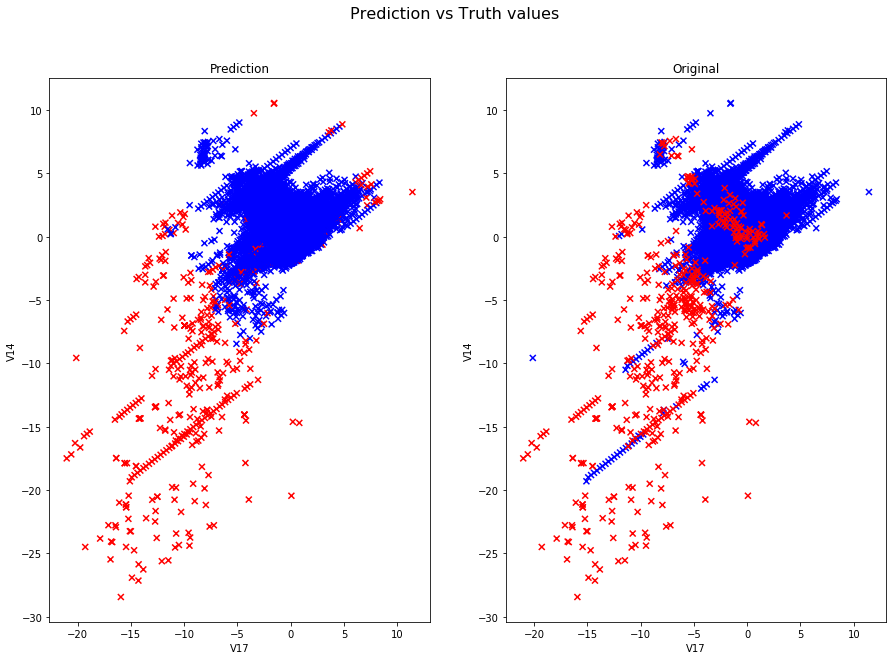

In [31]:

final_scores = final_model.decision_function(scaled_X)
final_threshold = np.quantile(final_scores, optimal_q)
final_pred =np.array((final_scores < final_threshold)*1) 

plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('Prediction vs Truth values', fontsize=16)
ax1.scatter(scaled_X['V14'], scaled_X['V17'], c = final_pred, marker = 'x', cmap = 'bwr')
ax1.set_xlabel('V17')
ax1.set_ylabel('V14')
ax1.set_title('Prediction')
ax2.scatter(scaled_X['V14'], scaled_X['V17'], c = targets, marker = 'x', cmap = 'bwr')
ax2.set_xlabel('V17')
ax2.set_ylabel('V14')
ax2.set_title('Original')
plt.show()

#### Finally, all data points were visualized using scatter plots. In the left plot, blue points represent transactions classified as normal by the final decision threshold, while red points indicate those classified as fraudulent. The right-hand plot shows the true class labels for comparison.

#### Since fraud detection is an unsupervised problem in practice, the final threshold was determined using all available data, simulating a real-world deployment scenario in which ground-truth labels are not accessible.